<a href="https://colab.research.google.com/github/iamhero2709/Learning-Projects-Notebook/blob/main/ml_projects/Kernel_SVM_scratch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KERNEL SVM CODE FROM SCARTCH
---

In [3]:
import numpy as np


In [7]:
#kernel function
def kernel_function(x1,x2):
  return np.dot(x1,x2)
def plynomial_kernel(x1,x2,degree=3,coef=1):
  return (np.dot(x1,x2)+coef)**degree
def rbf_kernel(x1,x2,gamma=1):
  return np.exp(-gamma*np.linalg.norm(x1-x2)**2)

In [5]:
class KernelSVM:
    def __init__(self, C=1.0, kernel='rbf', degree=3, gamma=1.0, coef=1, tol=1e-3, max_passes=5):
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.kernel_type = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef = coef

    def _kernel(self, x1, x2):
        if self.kernel_type == 'linear':
            return linear_kernel(x1, x2)
        elif self.kernel_type == 'poly':
            return polynomial_kernel(x1, x2, self.degree, self.coef)
        elif self.kernel_type == 'rbf':
            return rbf_kernel(x1, x2, self.gamma)
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y <= 0, -1, 1)
        self.X = X
        self.y = y
        self.alpha = np.zeros(n_samples)
        self.b = 0
        passes = 0

        while passes < self.max_passes:
            alpha_changed = 0
            for i in range(n_samples):
                Ei = self._predict_row(i) - y[i]
                if (y[i]*Ei < -self.tol and self.alpha[i] < self.C) or (y[i]*Ei > self.tol and self.alpha[i] > 0):
                    # Select j != i randomly
                    j = np.random.choice([x for x in range(n_samples) if x != i])
                    Ej = self._predict_row(j) - y[j]

                    alpha_i_old = self.alpha[i]
                    alpha_j_old = self.alpha[j]

                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue

                    eta = 2 * self._kernel(X[i], X[j]) - self._kernel(X[i], X[i]) - self._kernel(X[j], X[j])
                    if eta >= 0:
                        continue

                    self.alpha[j] -= y[j] * (Ei - Ej) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)

                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue

                    self.alpha[i] += y[i]*y[j]*(alpha_j_old - self.alpha[j])

                    # Update b
                    b1 = self.b - Ei - y[i]*(self.alpha[i]-alpha_i_old)*self._kernel(X[i], X[i]) - y[j]*(self.alpha[j]-alpha_j_old)*self._kernel(X[i], X[j])
                    b2 = self.b - Ej - y[i]*(self.alpha[i]-alpha_i_old)*self._kernel(X[i], X[j]) - y[j]*(self.alpha[j]-alpha_j_old)*self._kernel(X[j], X[j])

                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    alpha_changed += 1
            if alpha_changed == 0:
                passes += 1
            else:
                passes = 0

        # Save support vectors
        self.support_ = self.alpha > 1e-5
        self.support_vectors_ = self.X[self.support_]
        self.support_alpha = self.alpha[self.support_]
        self.support_y = self.y[self.support_]

    def _predict_row(self, i):
        result = 0
        for j in range(len(self.alpha)):
            result += self.alpha[j] * self.y[j] * self._kernel(self.X[i], self.X[j])
        return result + self.b

    def predict(self, X):
        y_pred = []
        for x in X:
            result = 0
            for i in range(len(self.support_alpha)):
                result += self.support_alpha[i] * self.support_y[i] * self._kernel(self.support_vectors_[i], x)
            y_pred.append(np.sign(result + self.b))
        return np.array(y_pred)

In [8]:
# tetsing on non linerly speprble
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Data
X, y = make_circles(n_samples=400, factor=0.5, noise=0.1)
y = np.where(y == 0, -1, 1)

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model
svm = KernelSVM(C=1.0, kernel='rbf', gamma=1.0)
svm.fit(X_train, y_train)

# Accuracy
train_acc = accuracy_score(y_train, svm.predict(X_train))
test_acc = accuracy_score(y_test, svm.predict(X_test))

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")



Train Accuracy: 1.0000
Test Accuracy : 1.0000


In [9]:
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title(title)
    plt.grid(True)
    plt.show()


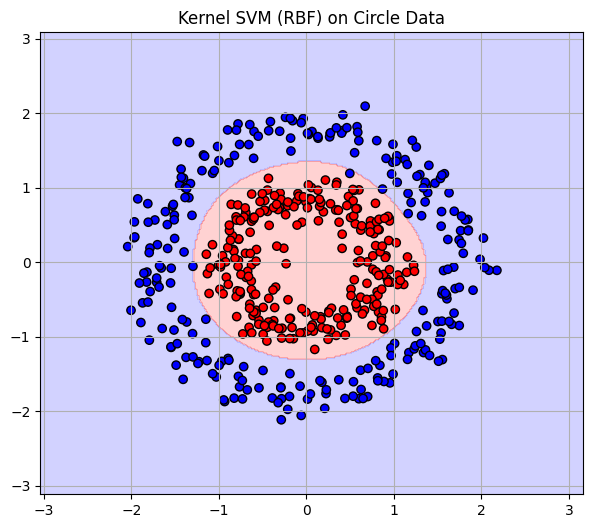

In [10]:
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler

X, y = make_circles(n_samples=500, noise=0.1, factor=0.5)
y = np.where(y == 0, -1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = KernelSVM(C=1.0, kernel='rbf', gamma=1.0)
model.fit(X_scaled, y)
plot_decision_boundary(model, X_scaled, y, title="Kernel SVM (RBF) on Circle Data")


RBF (Circle Data) Accuracy: 0.9933


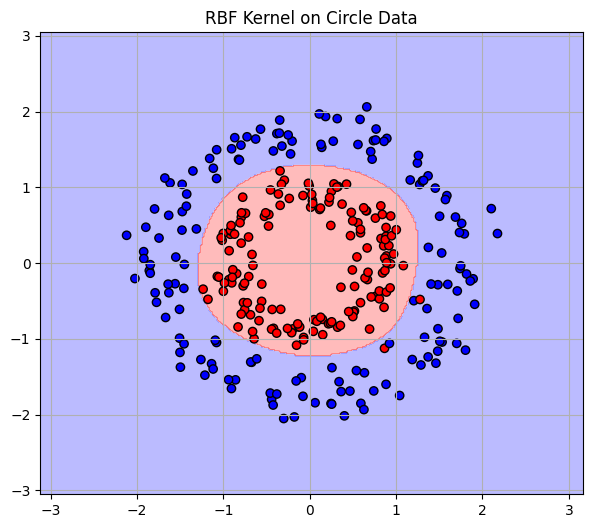

Linear Kernel (Linear Data) Accuracy: 1.0000


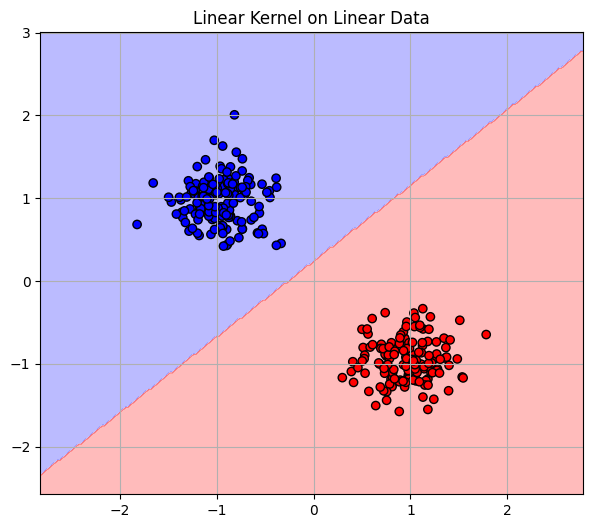

Polynomial Kernel (Circle Data) Accuracy: 0.9900


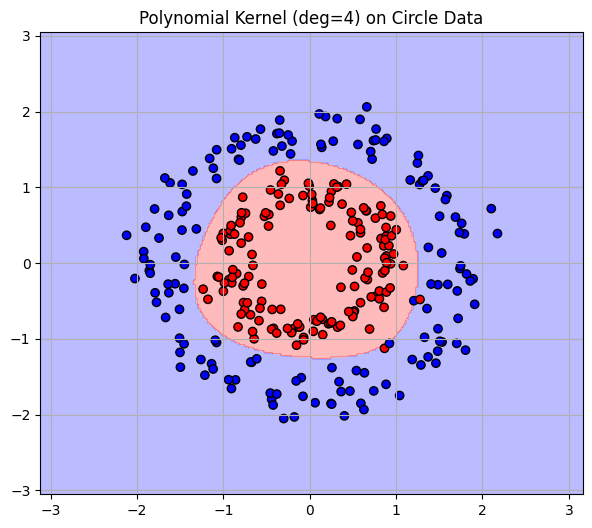

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# ------------ Kernel Functions ------------
def linear_kernel(x1, x2): return np.dot(x1, x2)
def polynomial_kernel(x1, x2, degree=3, coef=1): return (np.dot(x1, x2) + coef) ** degree
def rbf_kernel(x1, x2, gamma=1): return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# ------------ Kernel SVM Class ------------
class KernelSVM:
    def __init__(self, C=1.0, kernel='rbf', degree=3, gamma=1.0, coef=1, tol=1e-3, max_passes=5):
        self.C = C
        self.kernel_type = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef = coef
        self.tol = tol
        self.max_passes = max_passes

    def _kernel(self, x1, x2):
        if self.kernel_type == 'linear':
            return linear_kernel(x1, x2)
        elif self.kernel_type == 'poly':
            return polynomial_kernel(x1, x2, self.degree, self.coef)
        elif self.kernel_type == 'rbf':
            return rbf_kernel(x1, x2, self.gamma)
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = np.where(y <= 0, -1, 1)
        self.X, self.y = X, y
        self.alpha = np.zeros(n_samples)
        self.b = 0
        passes = 0

        while passes < self.max_passes:
            alpha_changed = 0
            for i in range(n_samples):
                Ei = self._predict_row(i) - y[i]
                if (y[i]*Ei < -self.tol and self.alpha[i] < self.C) or (y[i]*Ei > self.tol and self.alpha[i] > 0):
                    j = np.random.choice([x for x in range(n_samples) if x != i])
                    Ej = self._predict_row(j) - y[j]
                    alpha_i_old = self.alpha[i]
                    alpha_j_old = self.alpha[j]

                    if y[i] != y[j]:
                        L = max(0, self.alpha[j] - self.alpha[i])
                        H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                    else:
                        L = max(0, self.alpha[i] + self.alpha[j] - self.C)
                        H = min(self.C, self.alpha[i] + self.alpha[j])
                    if L == H:
                        continue

                    eta = 2 * self._kernel(X[i], X[j]) - self._kernel(X[i], X[i]) - self._kernel(X[j], X[j])
                    if eta >= 0:
                        continue

                    self.alpha[j] -= y[j] * (Ei - Ej) / eta
                    self.alpha[j] = np.clip(self.alpha[j], L, H)
                    if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    self.alpha[i] += y[i]*y[j]*(alpha_j_old - self.alpha[j])

                    b1 = self.b - Ei - y[i]*(self.alpha[i]-alpha_i_old)*self._kernel(X[i], X[i]) - y[j]*(self.alpha[j]-alpha_j_old)*self._kernel(X[i], X[j])
                    b2 = self.b - Ej - y[i]*(self.alpha[i]-alpha_i_old)*self._kernel(X[i], X[j]) - y[j]*(self.alpha[j]-alpha_j_old)*self._kernel(X[j], X[j])
                    if 0 < self.alpha[i] < self.C:
                        self.b = b1
                    elif 0 < self.alpha[j] < self.C:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

                    alpha_changed += 1
            passes = passes + 1 if alpha_changed == 0 else 0

        self.support_ = self.alpha > 1e-5
        self.support_vectors_ = self.X[self.support_]
        self.support_alpha = self.alpha[self.support_]
        self.support_y = self.y[self.support_]

    def _predict_row(self, i):
        result = 0
        for j in range(len(self.alpha)):
            result += self.alpha[j] * self.y[j] * self._kernel(self.X[i], self.X[j])
        return result + self.b

    def predict(self, X):
        y_pred = []
        for x in X:
            result = 0
            for i in range(len(self.support_alpha)):
                result += self.support_alpha[i] * self.support_y[i] * self._kernel(self.support_vectors_[i], x)
            y_pred.append(np.sign(result + self.b))
        return np.array(y_pred)

# ------------ Plot Function ------------
def plot_decision_boundary(model, X, y, title="SVM Decision Boundary"):
    h = 0.02
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title(title)
    plt.grid(True)
    plt.show()

# ------------ Dataset 1: Circle (RBF Kernel) ------------
X1, y1 = make_circles(n_samples=300, factor=0.5, noise=0.1)
y1 = np.where(y1 == 0, -1, 1)
sc1 = StandardScaler()
X1 = sc1.fit_transform(X1)

svm1 = KernelSVM(C=1.0, kernel='rbf', gamma=1)
svm1.fit(X1, y1)
acc1 = accuracy_score(y1, svm1.predict(X1))
print(f"RBF (Circle Data) Accuracy: {acc1:.4f}")
plot_decision_boundary(svm1, X1, y1, "RBF Kernel on Circle Data")

# ------------ Dataset 2: Linearly Separable (Linear Kernel) ------------
X2, y2 = make_blobs(n_samples=300, centers=2, random_state=42)
y2 = np.where(y2 == 0, -1, 1)
sc2 = StandardScaler()
X2 = sc2.fit_transform(X2)

svm2 = KernelSVM(C=1.0, kernel='linear')
svm2.fit(X2, y2)
acc2 = accuracy_score(y2, svm2.predict(X2))
print(f"Linear Kernel (Linear Data) Accuracy: {acc2:.4f}")
plot_decision_boundary(svm2, X2, y2, "Linear Kernel on Linear Data")

# ------------ Dataset 3: Circle with Polynomial Kernel ------------
svm3 = KernelSVM(C=1.0, kernel='poly', degree=4, coef=1)
svm3.fit(X1, y1)
acc3 = accuracy_score(y1, svm3.predict(X1))
print(f"Polynomial Kernel (Circle Data) Accuracy: {acc3:.4f}")
plot_decision_boundary(svm3, X1, y1, "Polynomial Kernel (deg=4) on Circle Data")
